久保拓弥『データ解析のための統計モデリング入門』をJuliaでやってみます。

* 久保さんの書籍ページ：http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html
* Amazon.co.jp：https://amzn.to/2Cg5vDJ

# 第5章 GLMの尤度比検定と検定の非対称性

In [16]:
using CSV
using DataFrames
using GLM
using Plots
pyplot();
using Distributions

## 5.2 尤度比検定の例題：逸脱度の差を調べる

In [17]:
d = CSV.read("data3a.csv");
fit1 = glm(@formula(y ~ 1), d, Poisson(), LogLink());
fit2 = glm(@formula(y ~ x), d, Poisson(), LogLink());

**尤度比**（_likelihood ratio_）を対数化して-2をかけたものが逸脱度の差$\Delta D$になる。
$$ \frac{L_1^\ast}{L_2^\ast} $$
$$ \Delta D_{1,2} = -2\times\left(\log L_1^\ast - \log L_2^\ast\right) $$

In [18]:
D1 = -2 * loglikelihood(fit1)
D2 = -2 * loglikelihood(fit2)
deltaD = D1 - D2   # deviance(fit1) - deviance(fit2) でも同じ

4.5139410788519285

この4.5という値の大きさが十分なのかどうかをどうやって確認するの？というのが、この後の中心的な話題。

## 5.4 帰無仮説を棄却するための有意水準

### 5.4.1 方法(1) 汎用性のあるパラメトリックブートストラップ法（p.102）



In [19]:
deviance(fit1) - deviance(fit2)

4.513941078851829

In [20]:
d[:y_rnd] = rand(Poisson(mean(d[:y])), 100)

100-element Array{Int64,1}:
  9
 12
  9
  7
  6
  7
  6
  4
  8
  9
  6
  7
  7
 10
  6
  4
 12
 12
  5
 10
  8
  7
 13
  6
  3
  6
  ⋮
 13
  6
  9
  8
  8
  9
  9
  7
  7
  4
 10
  7
  7
 12
  6
  5
 10
  6
  4
  8
  7
  6
  4
  5
  2

In [21]:
d

,y,x,f,y_rnd
,Int64⍰,Float64⍰,String⍰,Int64
1,6,8.31,C,9
2,6,9.44,C,12
3,6,9.5,C,9
4,12,9.07,C,7
5,10,10.16,C,6
6,4,8.32,C,7
7,9,10.61,C,6
8,9,10.06,C,4
9,9,9.93,C,8


In [22]:
fit1 = glm(@formula(y_rnd ~ 1), d, Poisson(), LogLink())
fit2 = glm(@formula(y_rnd ~ x), d, Poisson(), LogLink())
deviance(fit1) - deviance(fit2)

4.758851470322483

これを1000回くらい繰り返して、ランダム生成したデータの逸脱度の差の平均や標準偏差をみる。単純な方法は以下の`for`を使うやり方。

In [23]:
N = 1000
dd12 = zeros(N)
for n=1:N
    d[:y_rnd] = rand(Poisson(mean(d[:y])), 100)
    fit1 = glm(@formula(y_rnd ~ 1), d, Poisson(), LogLink())
    fit2 = glm(@formula(y_rnd ~ x), d, Poisson(), LogLink())
    dd12[n] = deviance(fit1) - deviance(fit2)
end

p.104のコードをJuliaで書くと以下のようになるだろうか。`replicate()`の代わりにarray comprehensionを使った。

In [24]:
function get_dd(d)
    n_sample = nrow(d)
    y_mean = mean(d[:y])
    d[:y_rnd] = rand(Poisson(mean(d[:y])), 100)
    fit1 = glm(@formula(y_rnd ~ 1), d, Poisson(), LogLink())
    fit2 = glm(@formula(y_rnd ~ x), d, Poisson(), LogLink())
    return(deviance(fit1) - deviance(fit2))
end

function pb(d, n_bootstrap)
    [get_dd(d) for n=1:n_bootstrap]
end

N = 1000
dd12 = pb(d, N)

1000-element Array{Float64,1}:
 0.06839055370872416 
 0.04880997994490599 
 4.532695464480554   
 0.39306890761984903 
 2.5792142759311787  
 0.01039657254573001 
 1.1468529255133149  
 1.2983618040553324  
 0.04217905891715645 
 0.8217641750176483  
 0.2609324943704081  
 0.14230921926474593 
 1.7082438703121454  
 0.015527639944835414
 0.4619689665044149  
 0.1082840890532708  
 0.3278047032947171  
 3.6029580791422546  
 1.0697302913477387  
 0.11296466598311383 
 0.05660930909964179 
 2.013511489977944   
 1.4129559603041315  
 1.0410483737468752  
 1.9971744383950778  
 0.10678448075620395 
 ⋮                   
 0.5955245764344568  
 0.45407692928998244 
 0.007289312166776085
 0.6072963454358131  
 1.7503103540690574  
 1.5163278576704045  
 0.9999916376693108  
 0.017780131549699263
 0.009402111809492908
 0.6456066524455224  
 0.13671684091248437 
 0.05835297571169917 
 0.016807588066967583
 1.7984827789919393  
 0.7129289731974922  
 0.6253043786080781  
 0.5158850942439415  
 

In [25]:
describe(dd12)

Summary Stats:
Mean:           0.965717
Minimum:        0.000000
1st Quartile:   0.090692
Median:         0.455606
3rd Quartile:   1.375165
Maximum:        10.157710
Length:         1000
Type:           Float64


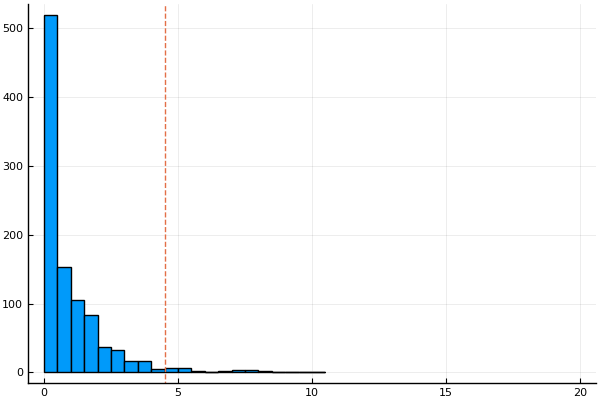

In [26]:
histogram(dd12, xlim=[0, 20], legend=false)
vline!([deltaD], linestyle=:dash)

In [27]:
sum(dd12 .>= deltaD)

31

In [28]:
p_value = sum(dd12 .>= deltaD) / length(dd12)

0.031

In [29]:
α = 0.05
quantile(dd12, 1-α)

3.5225218499664783

有意水準5%では上記の数値くらいまでの逸脱度の差は「よくある差」だと判断できる。

### 3.4.2 方法(2) カイ二乗分布を使った近似計算法

JuliaにRのようなANOVAは無さそうなので、コード例をそのままJuliaに移植することはできない。でもカイ二乗分布の累積分布関数を使ってp値を求めることはできる。

In [30]:
fit1 = glm(@formula(y ~ 1), d, Poisson(), LogLink())
fit2 = glm(@formula(y ~ x), d, Poisson(), LogLink())
dd12 = deviance(fit1) - deviance(fit2)
1 - cdf(Chisq(1), dd12)

0.03361969100898521